# Packages

In [1]:
!pip install yfinance

In [2]:
!pip install openpxyl

ERROR: Could not find a version that satisfies the requirement openpxyl (from versions: none)
ERROR: No matching distribution found for openpxyl


In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Functions

In [2]:
def split_and_expand(row):
    """Split a string data accross coma
    """
    return pd.Series(row.split(','))   

def raw_data_to_dataframe(df_unseparated):
    """From a raw DataFrame returns a clean DataFrame separated on the coma.
    """ 

    columns_name = df_unseparated.columns[0].split(',')

    values = df_unseparated['Date,Open,High,Low,Close,Adj Close,Volume'].apply(split_and_expand).values

    return pd.DataFrame(values, columns=columns_name)

def df_of_aggregated_data(df_raw):
    """From Yahoo.fr export, returns a dataframe with the asset as ticker.
    """
    df_aggregated = pd.DataFrame()

    for indice in list(df_raw.keys()):
        df_raw[indice] = raw_data_to_dataframe(df_raw[indice])
        # Add the ticker on the dataframe
        df_raw[indice]['Ticker'] = [indice]*len(df_raw[indice])
        # concat all the data frame
        df_aggregated = pd.concat([df_aggregated, df_raw[indice]], axis=0)

    return df_aggregated.set_index('Date')


def convert_index_to_datetime(df):
    """
    Convert the index of a DataFrame from a string date format (YYYY-MM-DD) to datetime format.
    
    Parameters:
    - df: pandas DataFrame
    
    Returns:
    - pandas DataFrame with the index converted to datetime format
    """
    # Check if the DataFrame has an index
    if not isinstance(df.index, pd.DatetimeIndex):
        # Convert the index to datetime format
        df.index = pd.to_datetime(df.index)
    
    return df
    
def transform_df_with_str_values_into_float(df, columns_to_change):
    df[columns_to_change] = df[columns_to_change].apply(pd.to_numeric, errors='coerce')
    return df

def crop_dataframe(df, begin_date='1000-01-01', end_date='3000-01-01', all_dates=False):
    """
    Crop a DataFrame between two specified dates, keeping all occurrences of the dates if specified.

    Parameters:
    - df: pandas DataFrame
    - begin_date: str, format 'YYYY-MM-DD'
    - end_date: str, format 'YYYY-MM-DD'
    - all_dates: bool, if True, keep all data, regardless of the date interval (default: False)

    Returns:
    - pandas DataFrame cropped between begin_date and end_date (or the original DataFrame if all_dates is True)
    """
    # If all_dates is True, return the original DataFrame
    if all_dates:
        return df
    
    else:
        # Convert input dates to datetime format
        begin_date = pd.to_datetime(begin_date)
        end_date = pd.to_datetime(end_date)

        # Boolean indexing to keep all occurrences of dates within the specified interval
        cropped_df = df[(df.index >= begin_date) & (df.index <= end_date)]

        return cropped_df


# Functions for empirical moments
def get_mu_hat(gross_returns_table, end_date_for_the_empirical_sum):
    
    mu_hat_TIME_T = gross_returns_table.loc[:pd.to_datetime(end_date_for_the_empirical_sum)].mean(axis=0)

    return mu_hat_TIME_T.values

def get_omega_hat(gross_returns_table, end_date_for_the_empirical_sum):
    mu_hat = get_mu_hat(gross_returns_table=gross_returns_table, end_date_for_the_empirical_sum=end_date_for_the_empirical_sum)
    Y_minus_mu_hat = gross_returns_table - mu_hat

    omega_hat = np.zeros((len(Y_minus_mu_hat.columns),len(Y_minus_mu_hat.columns)))
    
    for date in Y_minus_mu_hat.index:
        Y_date_minus_mu_hat = Y_minus_mu_hat.loc[date].values.reshape(len(Y_minus_mu_hat.columns), 1)
        matrix_product_for_date = np.dot(Y_date_minus_mu_hat, Y_date_minus_mu_hat.T)
        omega_hat += matrix_product_for_date

    omega_hat /= len(omega_hat)
    
    return omega_hat


In [3]:
def create_stock_dataframe(tickers, start_date, end_date):
    data = {} 

    for ticker in tickers:
        # Pour télécharger les données boursières avec une fréquence mensuelle "1mo"
        stock_data = yf.download(ticker, start=start_date, end=end_date, interval='1mo')
        # Pour extraire et stocker les prix de clôture ajustés "Adj Close"
        data[ticker] = stock_data['Adj Close']
    df = pd.DataFrame(data)
    
    return df


# Download and clean data

In [4]:
# Créaiton du DataFrame
tickers = ['JPM', 'BP', 'AAPL']
start_date = '2020-01-01'
end_date = '2023-12-01'
stock_df = create_stock_dataframe(tickers, start_date, end_date)
stock_df


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,JPM,BP,AAPL
Date,,,
2020-01-01,117.284706,29.154238,75.383644
2020-02-01,103.546021,25.248714,66.579010
2020-03-01,80.288078,20.020252,62.081348
2020-04-01,85.398048,19.535961,71.727165
2020-05-01,87.682083,18.994202,77.620613
2020-06-01,84.753662,19.656654,89.301903
2020-07-01,87.078392,18.577732,104.048485
2020-08-01,91.156837,17.642103,126.354385
2020-09-01,87.590286,14.910810,113.604179


# Plot index evolution

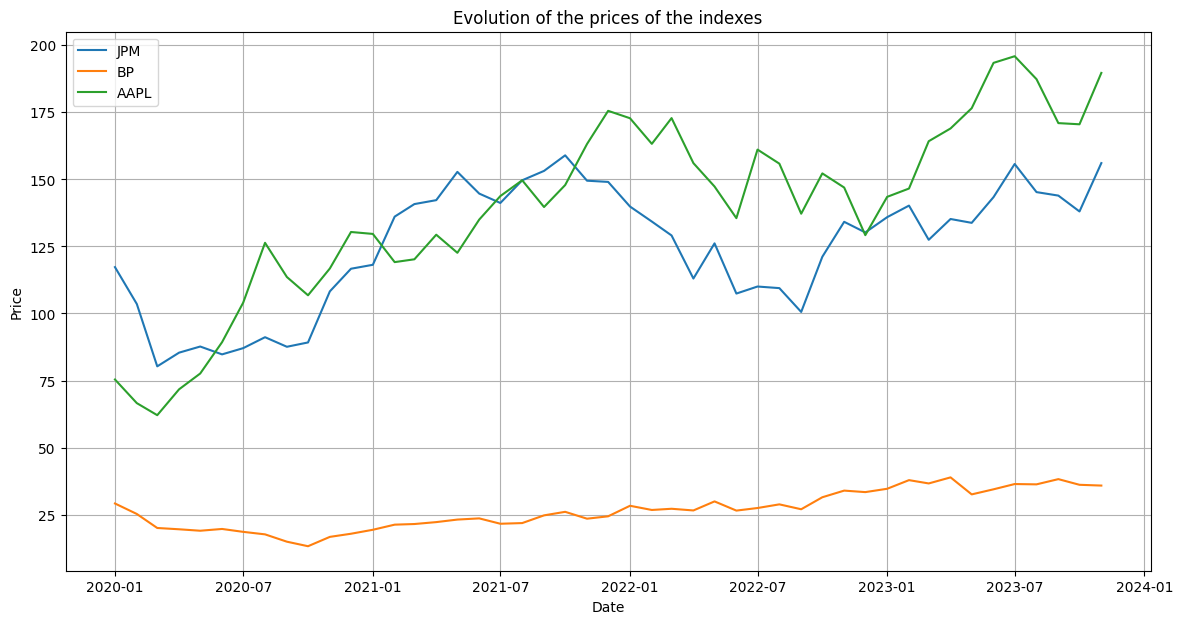

In [5]:
plt.figure(figsize=(14, 7))
for c in stock_df.columns.values:
    plt.plot(stock_df.index, stock_df[c], label=c)
plt.legend()
plt.grid()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Evolution of the prices of the indexes')
plt.show()

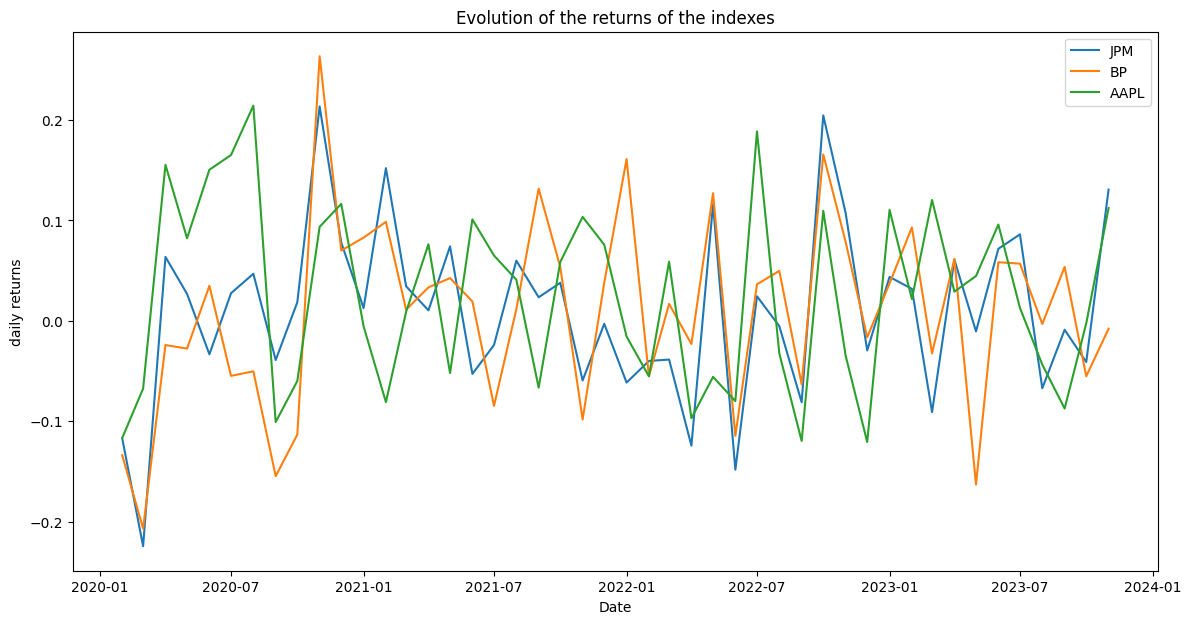

In [6]:
returns = stock_df.pct_change()

plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], label=c)
plt.legend()
plt.ylabel('daily returns')
plt.xlabel('Date')
plt.title('Evolution of the returns of the indexes')
plt.show()

# Efficient frontier representation

## Test the stationarity of the returns

In [7]:
# For testing stationarity
P_VALUE = 0.01

In [8]:
Y = returns+1
Y_full = Y.iloc[1:]

for index in Y.columns:
    # ADF Test for Stationarity
    result = adfuller(Y_full[index].values, autolag='AIC')

    # Extract and print the results
    adf_statistic = result[0]
    p_value = result[1]
    critical_values = result[4]

    print('__________________________')
    print(f'Stationarity test for {index[1]} index')
    print(f'ADF Statistic: {adf_statistic}')
    print(f'p-value: {p_value}')
    print('Critical Values:')
    for key, value in critical_values.items():
        print(f'   {key}: {value}')

    # Interpret the results
    if p_value <= P_VALUE:
        print(f'Then for a p-value of {P_VALUE}, the time series is likely stationary (reject the null hypothesis of non-stationarity).')
    else:
        print(f'Then for a p-value of {P_VALUE}, the time series is likely non-stationary (fail to reject the null hypothesis).')

__________________________
Stationarity test for P index
ADF Statistic: -3.207295607855409
p-value: 0.01956624564206257
Critical Values:
   1%: -3.5925042342183704
   5%: -2.931549768951162
   10%: -2.60406594375338
Then for a p-value of 0.01, the time series is likely non-stationary (fail to reject the null hypothesis).
__________________________
Stationarity test for P index
ADF Statistic: -6.570943990864176
p-value: 7.939174118456678e-09
Critical Values:
   1%: -3.584828853223594
   5%: -2.9282991495198907
   10%: -2.6023438271604937
Then for a p-value of 0.01, the time series is likely stationary (reject the null hypothesis of non-stationarity).
__________________________
Stationarity test for A index
ADF Statistic: -5.750899395543809
p-value: 5.969973490735691e-07
Critical Values:
   1%: -3.5885733964124715
   5%: -2.929885661157025
   10%: -2.6031845661157025
Then for a p-value of 0.01, the time series is likely stationary (reject the null hypothesis of non-stationarity).


## Empirical moments

In [9]:
TIME_T = end_date

In [10]:
mu_hat = get_mu_hat(gross_returns_table=Y_full, end_date_for_the_empirical_sum=TIME_T)
mu_hat

array([1.00988265, 1.00874351, 1.0242488 ])

In [11]:
omega_hat =get_omega_hat(gross_returns_table=Y_full, end_date_for_the_empirical_sum=TIME_T)
omega_hat

array([[0.11162806, 0.08234607, 0.04117035],
       [0.08234607, 0.13005722, 0.02140963],
       [0.04117035, 0.02140963, 0.12523776]])

# Efficient Frontier: Gamma Markowitz

In [12]:
def objective(weights, gamma, returns, cov_matrix):
    """_summary_

    Args:
        weights (_type_): Column vector of the weights
        gamma (_type_): Inverse of the risk aversion parameter
        returns (_type_):  Column vector of the expected returns
        cov_matrix (_type_): Matrix of covariance

    Returns:
        _type_: _description_
    """
    x_star = 1/2 * weights.T @ cov_matrix @ weights - gamma * weights.T @ returns
    return x_star


def constraint_fully_invested(x_weights):
    return sum(x_weights) - 1

N_ASSETS=3

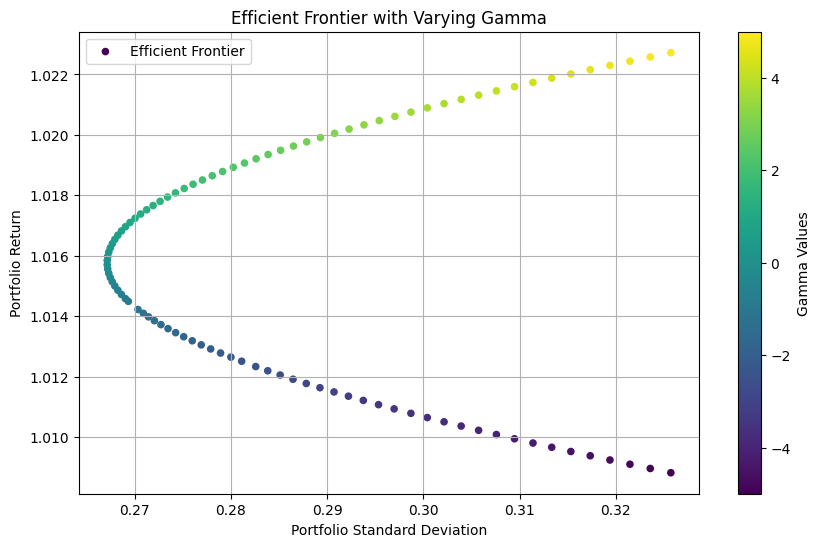

In [13]:
# Calculate the mean returns and covariance matrix
mean_returns = mu_hat
cov_matrix = omega_hat

# Define constraints
constraints = ({'type': 'eq', 'fun': constraint_fully_invested}) # fully invested portfolio
bounds = [(-1, 1)]* N_ASSETS # possession of asset in [-1, 1]

# Initialize weights
initial_weights = np.ones(N_ASSETS) / N_ASSETS

# Set gamma values
gamma_values = np.linspace(-5, 5, 100)  # Inverse of the risk aversion parameter

# Lists to store results
portfolio_returns = []
portfolio_std_devs = []
weights_gamma = []
objective_values = []

# Solve the problem for different values of gamma
for gamma_val in gamma_values:
    result = minimize(objective, initial_weights, args=(gamma_val, mean_returns, cov_matrix),
                      constraints=constraints, bounds=bounds)

    # Save results
    weights_gamma.append(list(result.x))
    portfolio_returns.append(np.dot(mean_returns, result.x))
    portfolio_std_devs.append(np.sqrt(np.dot(result.x.T, np.dot(cov_matrix, result.x))))
    objective_values.append(-result.fun)

# Plot the efficient frontier
plt.figure(figsize=(10, 6))
plt.scatter(portfolio_std_devs, portfolio_returns, s=20, c=gamma_values, cmap='viridis', label='Efficient Frontier')
plt.colorbar(label='Gamma Values')
plt.title('Efficient Frontier with Varying Gamma')
plt.xlabel('Portfolio Standard Deviation')
plt.ylabel('Portfolio Return')
plt.legend()
plt.grid(True)
# plt.xlim())
plt.show()



# The Tangent Portfolio : shap ratio

In [14]:
# propostion of risk-free asset in the portfolio
ALPHA = 0.1
# risk-free rate
RISK_FREE_RATE = 0.95
# Set gamma values
GAMMA_VALUES = np.linspace(-5, 5, 100)  # Inverse of the risk aversion parameter

In [15]:
def plot_efficient_frontier(mean_returns, cov_matrix, constraints, bounds, gamma_values, risk_free_rate, alpha, abscisse_0=True):
    initial_weights = np.ones(len(mean_returns)) / len(mean_returns)
    
    weights_gamma = []
    mu_x, mu_y = [], []
    sigma_x, sigma_y = [], []

    for gamma_val in gamma_values:
        result = minimize(objective, initial_weights, args=(gamma_val, mean_returns, cov_matrix),
                          constraints=constraints, bounds=bounds)
        weights_gamma.append(list(result.x))

        mu = np.dot(mean_returns, result.x)
        mu_x.append(mu)
        mu_y.append((1 - alpha) * risk_free_rate + alpha * mu)

        sigma = np.sqrt(np.dot(result.x.T, np.dot(cov_matrix, result.x)))
        sigma_x.append(sigma)
        sigma_y.append(alpha * sigma)

    tangente_theta = [(a - risk_free_rate) / b for a, b in zip(mu_y, sigma_y)]
    tangente_index = np.argmax(tangente_theta)
    gamma_tangent = gamma_values[tangente_index]
    mu_x_tangent = mu_x[tangente_index]
    sigma_x_tangent = sigma_x[tangente_index]

    # Plot the efficient frontier
    plt.figure(figsize=(10, 6))
    plt.scatter(sigma_x, mu_x, s=20, c=gamma_values, cmap='viridis', label='Efficient Frontier')
    plt.colorbar(label='Gamma Values')
    plt.scatter(x=sigma_x_tangent, y=mu_x_tangent, marker='X', s=50, c='r', label='Optimal Gamma')
    
    # Plot the tangent portfolio
    abscisses = [min(sigma_x) * 0.98, max(sigma_x)]
    ordonnées = [risk_free_rate + (mu_x_tangent - risk_free_rate) / sigma_x_tangent * min(sigma_x) * 0.98,
                 risk_free_rate + (mu_x_tangent - risk_free_rate) / sigma_x_tangent * max(sigma_x)]

    if abscisse_0:
        # Include ordinate of x=0
        abscisses.insert(0, 0)
        ordonnées.insert(0, RISK_FREE_RATE)

    plt.plot(abscisses, ordonnées, alpha=0.7, c='grey')

    plt.title(f'Efficient Frontier with Varying Gamma reach optimum at {gamma_tangent}.')
    plt.xlabel('Portfolio Standard Deviation')
    plt.ylabel('Portfolio Return')
    plt.legend()
    plt.grid(True)
    plt.show()

In [16]:
# Calculate the mean returns and covariance matrix
mean_returns = mu_hat
cov_matrix = omega_hat

# Define constraints
constraints = ({'type': 'eq', 'fun': constraint_fully_invested}) # fully invested portfolio
bounds = [(-1, 1)] * N_ASSETS # possession of asset in [-1, 1]

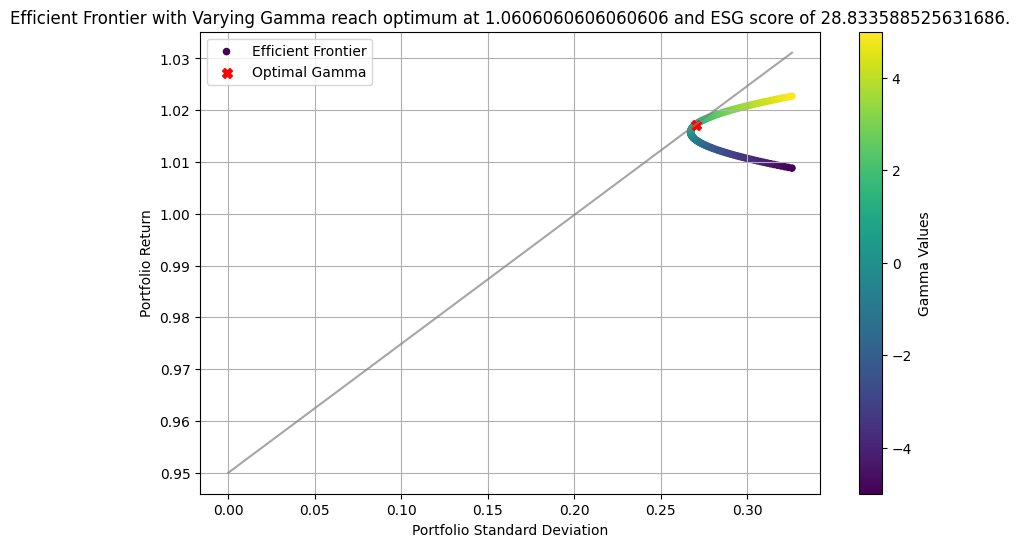

In [141]:
plot_efficient_frontier(mean_returns=mu_hat,
                        cov_matrix=omega_hat,
                        constraints={'type': 'eq', 'fun': constraint_fully_invested},
                        bounds=[(-1, 1)] * N_ASSETS,
                        gamma_values=GAMMA_VALUES,
                        risk_free_rate=RISK_FREE_RATE,
                        alpha=ALPHA,
                        abscisse_0=True)

# ESG Contrainte

## Focus on an unique max score

In [130]:
# Sustainalytics scores [APPL, BP, JPM] -> the smaller, the better
SUSTAINALYTICS_SCORES = [17.2, 34.6, 29.3]
# Score max
MAX_SCORE = 20

In [127]:
def constraint_ESG_max(x_weights):
    return - (np.dot(SUSTAINALYTICS_SCORES, x_weights) - MAX_SCORE) # minus for having inferior or equal in the constraint

def plot_efficient_frontier(mean_returns, cov_matrix, constraints, bounds, gamma_values, risk_free_rate, alpha, color_bar='gamma', abscisse_0=True):
    initial_weights = np.ones(len(mean_returns)) / len(mean_returns)

    weights_gamma = []
    mu_x, mu_y = [], []
    sigma_x, sigma_y = [], []
    objective_values = []
    score_esg = []

    for gamma_val in gamma_values:
        result = minimize(objective, initial_weights, args=(gamma_val, mean_returns, cov_matrix),
                          constraints=constraints, bounds=bounds)
        weights_gamma.append(list(result.x))

        mu = np.dot(mean_returns, result.x)
        mu_x.append(mu)
        mu_y.append((1 - alpha) * risk_free_rate + alpha * mu)

        sigma = np.sqrt(np.dot(result.x.T, np.dot(cov_matrix, result.x)))
        sigma_x.append(sigma)
        sigma_y.append(alpha * sigma)

        objective_values.append(-result.fun)

        score_esg.append(np.dot(SUSTAINALYTICS_SCORES, list(result.x)))

    tangente_theta = [(a - risk_free_rate) / b for a, b in zip(mu_y, sigma_y)]
    tangente_index = np.argmax(tangente_theta)
    gamma_tangent = gamma_values[tangente_index]
    mu_x_tangent = mu_x[tangente_index]
    sigma_x_tangent = sigma_x[tangente_index]
    score_esg_tangent = score_esg[tangente_index]

    # Plot the efficient frontier
    plt.figure(figsize=(10, 6))

    if color_bar == 'gamma':
        plt.scatter(sigma_x, mu_x, s=20, c=gamma_values, cmap='viridis', label='Efficient Frontier')
        plt.colorbar(label='Gamma Values')
    elif color_bar == 'esg':
        plt.scatter(sigma_x, mu_x, s=20, c=score_esg, cmap='seismic', label='Efficient Frontier')
        plt.colorbar(label='ESG score')
 
    plt.scatter(x=sigma_x_tangent, y=mu_x_tangent, marker='X', s=50, c='r', label='Optimal Gamma')
    
    # Plot the tangent portfolio
    abscisses = [min(sigma_x) * 0.98, max(sigma_x)]
    ordonnées = [risk_free_rate + (mu_x_tangent - risk_free_rate) / sigma_x_tangent * min(sigma_x) * 0.98,
                 risk_free_rate + (mu_x_tangent - risk_free_rate) / sigma_x_tangent * max(sigma_x)]
    
    if abscisse_0:
        # Include ordinate of x=0
        abscisses.insert(0, 0)
        ordonnées.insert(0, RISK_FREE_RATE)

        
    plt.plot(abscisses, ordonnées, alpha=0.7, c='grey')

    plt.title(f'Efficient Frontier with Varying Gamma reach optimum at {gamma_tangent} and ESG score of {score_esg_tangent}.')
    plt.xlabel('Portfolio Standard Deviation')
    plt.ylabel('Portfolio Return')
    plt.legend()
    plt.grid(True)
    plt.show()

In [128]:
# Calculate the mean returns and covariance matrix
mean_returns = get_mu_hat(gross_returns_table=Y_full, end_date_for_the_empirical_sum=TIME_T)
cov_matrix = get_omega_hat(gross_returns_table=Y_full, end_date_for_the_empirical_sum=TIME_T)

# Define constraintsx
constraints = ({'type': 'eq', 'fun': constraint_fully_invested}, # fully invested portfolio
               {'type': 'ineq', 'fun': constraint_ESG_max}) # ESG score inferior to a constant
bounds = [(-1, 1)] * N_ASSETS # possession of asset in [-1, 1]

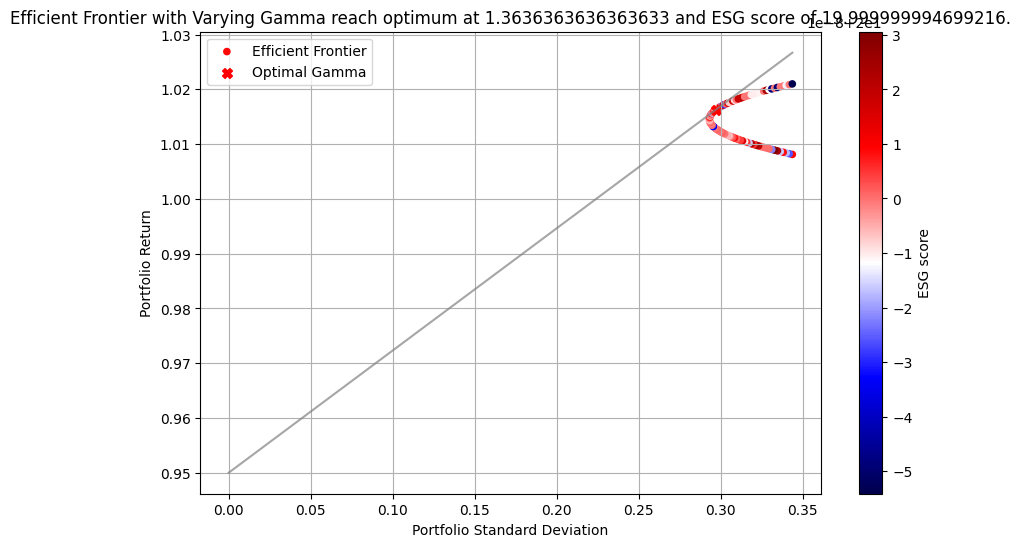

In [131]:
# Choose color bar type: 'gamma' or 'esg'
plot_efficient_frontier(mean_returns=mean_returns,
                        cov_matrix=cov_matrix,
                        constraints = constraints,
                        bounds=bounds,
                        gamma_values=GAMMA_VALUES,
                        risk_free_rate=RISK_FREE_RATE,
                        alpha=ALPHA,
                        color_bar='esg')

## Multiple ESG max score comparison

In [137]:
MAX_SCORES = np.linspace(np.min(SUSTAINALYTICS_SCORES), np.max(SUSTAINALYTICS_SCORES), 20)

In [138]:
def constraint_ESG_max(x_weights, max_score=MAX_SCORE):
    return - (np.dot(SUSTAINALYTICS_SCORES, x_weights) - max_score)

def get_efficient_frontier_data_multiple_max_esg_scores(mean_returns, cov_matrix, bounds, gamma_values, risk_free_rate, alpha, max_scores):
        
    data_dict = {}

    for max_score in max_scores:

        data_dict[max_score] = {}

        initial_weights = np.ones(len(mean_returns)) / len(mean_returns)

        weights_gamma = []
        mu_x, mu_y = [], []
        sigma_x, sigma_y = [], []
        objective_values = []
        score_esg = []

        for gamma_val in gamma_values:
            result = minimize(objective, initial_weights, args=(gamma_val, mean_returns, cov_matrix),
                            constraints=(
                                {'type': 'eq', 'fun': constraint_fully_invested},  # fully invested portfolio
                                {'type': 'ineq', 'fun': lambda x, max_score=max_score: constraint_ESG_max(x, max_score)}),
                            bounds=bounds)
            weights_gamma.append(list(result.x))

            mu = np.dot(mean_returns, result.x)
            mu_x.append(mu)
            mu_y.append((1 - alpha) * risk_free_rate + alpha * mu)

            sigma = np.sqrt(np.dot(result.x.T, np.dot(cov_matrix, result.x)))
            sigma_x.append(sigma)
            sigma_y.append(alpha * sigma)

            objective_values.append(-result.fun)

            score_esg.append(np.dot(SUSTAINALYTICS_SCORES, list(result.x)))

        tangente_theta = [(a - risk_free_rate) / b for a, b in zip(mu_y, sigma_y)]
        tangente_index = np.argmax(tangente_theta)
        gamma_tangent = gamma_values[tangente_index]
        mu_x_tangent = mu_x[tangente_index]
        sigma_x_tangent = sigma_x[tangente_index]
        score_esg_tangent = score_esg[tangente_index]

        data_dict[max_score]['mu_x'] = mu_x
        data_dict[max_score]['sigma_x'] = sigma_x
        data_dict[max_score]['mu_x_tangent'] = mu_x_tangent
        data_dict[max_score]['sigma_x_tangent'] = sigma_x_tangent
        data_dict[max_score]['gamma_tangent'] = gamma_tangent
        data_dict[max_score]['score_esg_tangent'] = score_esg_tangent
        data_dict[max_score]['tangente_theta'] = tangente_theta[tangente_index]
        
    return data_dict


def plot_efficient_frontier_data_multiple_max_esg_scores(mean_returns, cov_matrix, bounds, gamma_values, risk_free_rate, alpha, max_scores, abscisse_0 = True):

    data = get_efficient_frontier_data_multiple_max_esg_scores(mean_returns, cov_matrix, bounds, gamma_values, risk_free_rate, alpha, max_scores)

    # Générer une colormap en fonction de la taille de values_list
    cmap = plt.get_cmap('viridis')  # Vous pouvez choisir une autre colormap selon vos préférences
    colors = cmap(np.linspace(0, 1, len(list(data.keys()))))


    plt.figure(figsize=(10, 6))

    for idx, esg_score in enumerate(list(data.keys())):
        plt.plot(data[esg_score]['sigma_x'], data[esg_score]['mu_x'], c=colors[idx], label=f'Max ESG score of {np.round(esg_score, 1)}')

        # Plot the tangent portfolio
        abscisses = [min(data[esg_score]['sigma_x']) * 0.98, max(data[esg_score]['sigma_x'])]
        ordonnées = [RISK_FREE_RATE + (data[esg_score]['mu_x_tangent'] - RISK_FREE_RATE) / data[esg_score]['sigma_x_tangent'] * min(data[esg_score]['sigma_x']) * 0.98,
                    RISK_FREE_RATE + (data[esg_score]['mu_x_tangent'] - RISK_FREE_RATE) / data[esg_score]['sigma_x_tangent'] * max(data[esg_score]['sigma_x'])]

        if abscisse_0:
            # Include ordinate of x=0
            abscisses.insert(0, 0)
            ordonnées.insert(0, RISK_FREE_RATE)
            
        plt.plot(abscisses, ordonnées, alpha=0.7, c='grey')

    df_performance_esg_scores_debrief = pd.DataFrame([[key, data[key]["score_esg_tangent"], data[key]["gamma_tangent"], data[key]["tangente_theta"]] for key in list(data.keys())], columns=["max_score_esg","score_esg_tangent", "gamma_tangent", "tangente_theta"])

    plt.xlabel('Portfolio Standard Deviation')
    plt.ylabel('Portfolio Return')
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.grid(True)
    plt.title(f'Efficient Frontier with varying max ESG score')
    plt.show()

    return data, df_performance_esg_scores_debrief

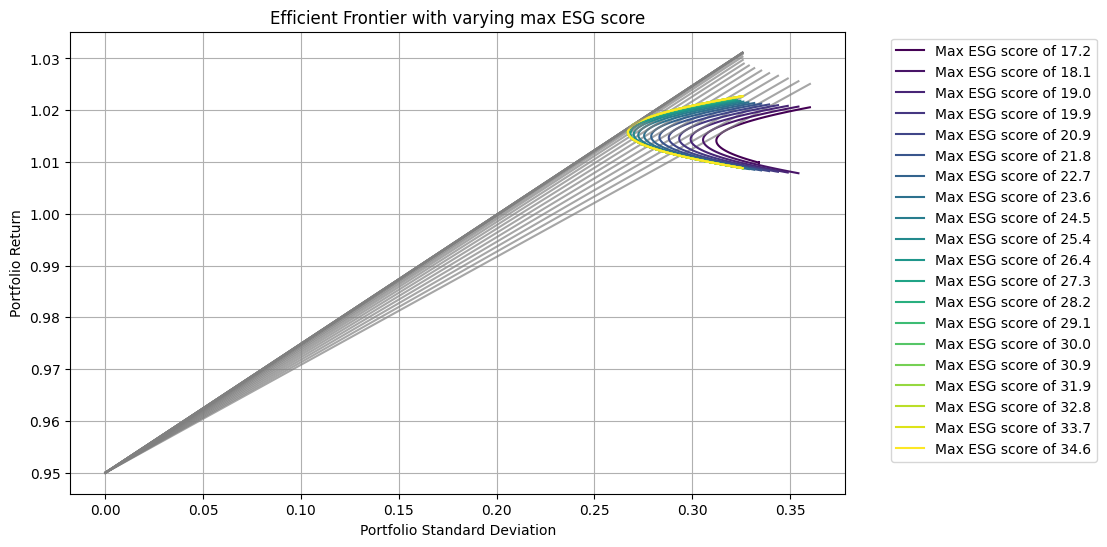

,max_score_esg,score_esg_tangent,gamma_tangent,tangente_theta
0,17.200000,17.200000,1.565657,0.208435
1,18.115789,18.115789,1.464646,0.213378
2,19.031579,19.031579,1.363636,0.218221
3,19.947368,19.947368,1.363636,0.222916
4,20.863158,20.863158,1.262626,0.227406
5,21.778947,21.778947,1.262626,0.231629
6,22.694737,22.694737,1.161616,0.235523
7,23.610526,23.610526,1.161616,0.239031
8,24.526316,24.526316,1.161616,0.242085
9,25.442105,25.442105,1.161616,0.244631


In [139]:
data, df_performance_esg_scores_debrief = plot_efficient_frontier_data_multiple_max_esg_scores(mean_returns = mean_returns,
                                                cov_matrix = cov_matrix,
                                                bounds = bounds,
                                                gamma_values = gamma_values,
                                                risk_free_rate = RISK_FREE_RATE,
                                                alpha = ALPHA,
                                                max_scores = MAX_SCORES,
                                                abscisse_0 = True)

df_performance_esg_scores_debrief

# Sharp Ratio en fonction MAX_SCORE

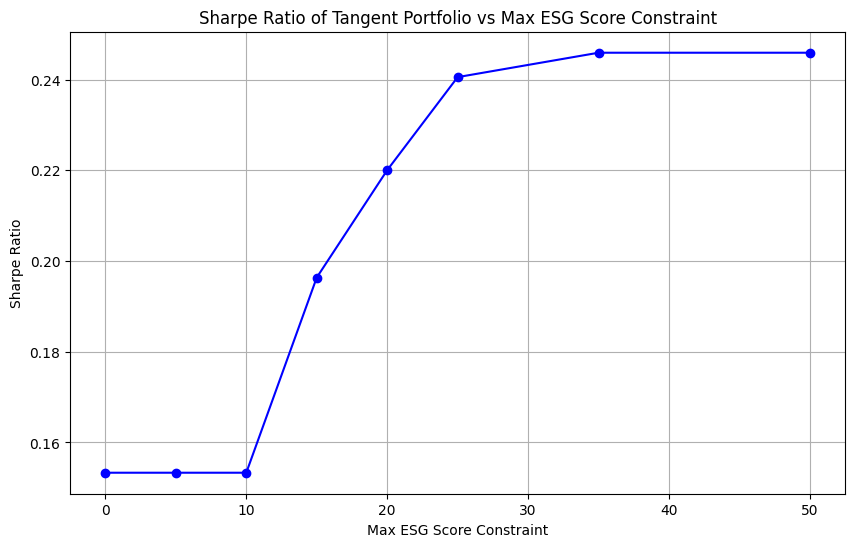

In [27]:
def constraint_ESG_max(x_weights, max_score):
    return - (np.dot(SUSTAINALYTICS_SCORES, x_weights) - max_score)

def plot_sharpe_ratio_vs_max_score(mean_returns, cov_matrix, bounds, gamma_values, risk_free_rate, alpha, max_scores):
    initial_weights = np.ones(len(mean_returns)) / len(mean_returns)

    sharpe_ratios = []

    for max_score in max_scores:
        constraints = [
            {'type': 'eq', 'fun': constraint_fully_invested},  # fully invested portfolio
            {'type': 'ineq', 'fun': lambda x, max_score=max_score: constraint_ESG_max(x, max_score)}
        ]
        objective_values = []
        for gamma_val in gamma_values:
            result = minimize(objective, initial_weights, args=(gamma_val, mean_returns, cov_matrix),
                              constraints=constraints, bounds=bounds)
            objective_values.append(-result.fun)

        tangente_theta = [(a - risk_free_rate) / b for a, b in zip(objective_values, gamma_values)]
        tangente_index = np.argmax(tangente_theta)
        gamma_tangent = gamma_values[tangente_index]

        # Calcul du Sharpe ratio du portefeuille tangent
        weights_tangent = minimize(objective, initial_weights, args=(gamma_tangent, mean_returns, cov_matrix),
                                   constraints=constraints, bounds=bounds).x
        mu_tangent = np.dot(mean_returns, weights_tangent)
        sigma_tangent = np.sqrt(np.dot(weights_tangent.T, np.dot(cov_matrix, weights_tangent)))
        sharpe_ratio = (mu_tangent - risk_free_rate) / sigma_tangent

        sharpe_ratios.append(sharpe_ratio)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(max_scores, sharpe_ratios, marker='o', linestyle='-', color='b')
    plt.title('Sharpe Ratio of Tangent Portfolio vs Max ESG Score Constraint')
    plt.xlabel('Max ESG Score Constraint')
    plt.ylabel('Sharpe Ratio')
    plt.grid(True)
    plt.show()

# Utilisation de la fonction
MAX_SCORES = [0, 5, 10, 15, 20, 25,35,50]
plot_sharpe_ratio_vs_max_score(mean_returns, cov_matrix, bounds, GAMMA_VALUES, RISK_FREE_RATE, ALPHA, MAX_SCORES)
